In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt

## 6.5.3 PCR and PLS Regression
### Principal Component Regression

In [2]:
hitters = pd.read_csv('../data/hitters.csv')
# drop nan values
hitters.dropna(axis=0, inplace=True)

# get dummy variables
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 0]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 0]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 0]

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [3]:
X = hitters.drop(['Salary'], axis=1)
y = hitters.Salary

In [4]:
pca = PCA()

X_pcr = pca.fit_transform(scale(X))

In [5]:
scores = []
explained_variance = []

# Compute the CV score for no principal compoents, linear regression only with intercept
scores.append(-np.mean(cross_val_score(LinearRegression(), 
                              np.ones((X.shape[0], 1)),
                              y, cv=10,
                              scoring='neg_mean_squared_error')))


for i in np.arange(1, X.shape[1]+1):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X)
    
    pca = PCA(n_components=i)
    X_pcr_i = pca.fit_transform(X_)
    
    score = -np.mean(cross_val_score(LinearRegression(),
                                    X_pcr_i[:, :i], y,
                                    cv=10, scoring='neg_mean_squared_error'))

    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    scores.append(score)

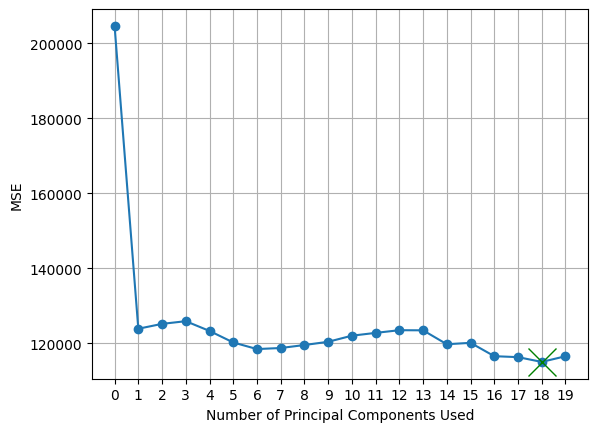

In [6]:
plt.plot(scores, marker='o')
plt.xlabel('Number of Principal Components Used')
plt.ylabel('MSE')
plt.xticks(np.arange(0, 20, 1))

plt.plot(np.argmin(scores), np.min(scores), 'gx', markersize=20)
plt.grid()

As we can see from the graph above, we get smallest cross-validation error when `n_components=18`. This is barely fewer than M = 19, which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.

In [7]:
# percentage of variance explanied
pd.Series(explained_variance, index=np.arange(1, 20))

1     0.383142
2     0.601553
3     0.708417
4     0.790342
5     0.842903
6     0.886348
7     0.922629
8     0.949630
9     0.962827
10    0.972554
11    0.979778
12    0.986487
13    0.991518
14    0.994730
15    0.997466
16    0.998940
17    0.999682
18    0.999938
19    1.000000
dtype: float64

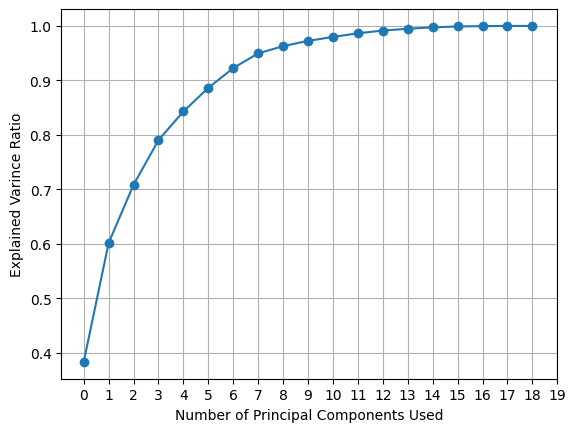

In [8]:
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Principal Components Used')
plt.ylabel('Explained Varince Ratio')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

M = 1 only captures 38.31 % of all the variance, or information, in the predictors. In contrast, using M = 5 increases the value to 84.29 %. If we were to use all M = p = 19 components, this would increase to 100 %.

In [9]:
pca2 = PCA()

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

X_pcr = pca2.fit_transform(scale(X_train))

kf = KFold(n_splits=10, shuffle=True, random_state=1)

MSEs = []
var_exp = []
# MSE with only the intercept
MSEs.append(-np.mean(cross_val_score(LinearRegression(), 
                              np.ones((X_pcr.shape[0], 1)),
                              y_train, cv=kf,
                              scoring='neg_mean_squared_error')))

for i in np.arange(1, 20):
    score = -np.mean(cross_val_score(LinearRegression(),
                                    X_pcr[:, :i], y_train,
                                    cv=kf, scoring='neg_mean_squared_error'))
    MSEs.append(score)

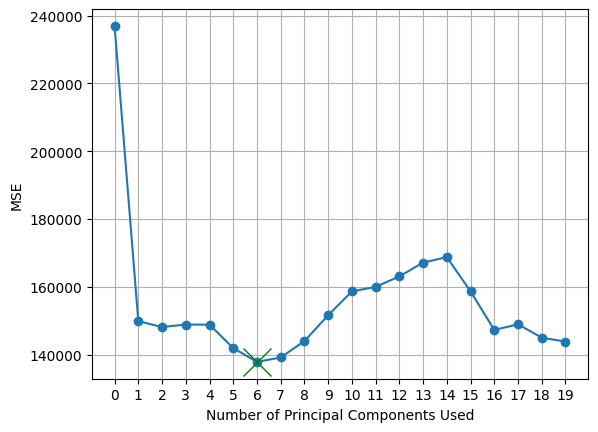

In [10]:
plt.plot(MSEs, marker='o')
plt.xlabel('Number of Principal Components Used')
plt.ylabel('MSE')
plt.xticks(np.arange(0, 20, 1))

plt.plot(np.argmin(MSEs), np.min(MSEs), 'gx', markersize=20)
plt.grid()

Now we find that the lowest cross-validation error occurs when M = 6 components are used.

In [11]:
X_pcr_test = pca2.transform(scale(X_test))[:, :7]

lm = LinearRegression()
lm.fit(X_pcr[:,:7], y_train)

pred = lm.predict(X_pcr_test)

# compute mean squared error 
mean_squared_error(y_test, pred)

111994.42273636982

### Partial Least Squares

In [12]:
scores_pls = []

for i in list(np.arange(1, X.shape[1]+1)):
    score = -np.mean(cross_val_score(PLSRegression(n_components=i),
                                    scale(X_train), y_train,
                                    cv=10, scoring='neg_mean_squared_error'))
    scores_pls.append(score)

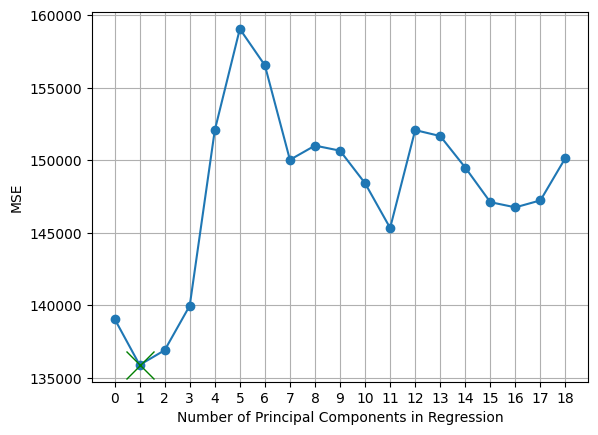

In [13]:
plt.plot(scores_pls, marker='o')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('MSE')
plt.xticks(np.arange(0, 20, 1))

plt.plot(np.argmin(scores_pls), np.min(scores_pls), 'gx', markersize=20)
plt.grid()

We get the lowest cross-validation error when only M = 1 partial least squares directions are used.

In [14]:
pls = PLSRegression(n_components=1)
pls.fit(scale(X_train), y_train)
pred = pls.predict(scale(X_test))

mean_squared_error(y_test, pred)

101780.51391077759